In [1]:
import pickle
import pandas as pd
import os
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [2]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRanked) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [3]:
run_list = os.listdir("results")

In [4]:
best_sol_pop = []
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        with open(rf"/home/khann/masters/results/{dir}/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)
            best_sol_pop.append(hof[0])
            best_sol_pop.append(hof[1])

In [5]:
best_sol_pop = []
cnt=0
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        if cnt == 0:
            df_tmp = pd.read_csv(rf"/home/khann/masters/results/{dir}/run_info.csv")
            df_tmp.drop('Unnamed: 0',axis=1, inplace=True)
        else:
            d = pd.read_csv(rf"/home/khann/masters/results/{dir}/run_info.csv")
            d.drop('Unnamed: 0',axis=1, inplace=True)
            df_tmp = pd.concat([df_tmp, d], ignore_index=True, sort=False)
        cnt+=1


In [6]:
df_tmp[df_tmp['strategy_value_train']>df_tmp['buy_hold_train']]


,population_number,generations,run_time,best_tree,trading_cost,buy_hold_train,strategy_value_train,buy_hold_test,strategy_value_test,time
1,100,50,23627,"or_(gt('ma_volume_37', 'ma_volume_22'), gt('ma...",1.0%,116918.977037,122542.497667,1163.710097,690.661582,2024-08-03 08:58:26.259925+00:00
4,100,50,23397,"or_(gt('ma_low_8', 'lag_low_43'), or_(gt('ma_v...",1.0%,116918.977037,170257.282652,1163.710097,1227.413153,2024-08-03 08:58:25.489257+00:00
5,100,50,23797,"or_(gt('ma_close_26', 'lag_close_42'), gt('ma_...",1.0%,116918.977037,152655.699058,1163.710097,902.983195,2024-08-03 08:58:26.471382+00:00
6,100,50,24121,"or_(and_(gt('lag_close_48', 'lag_low_48'), and...",1.0%,116918.977037,117770.378376,1163.710097,673.354055,2024-08-03 08:58:26.004065+00:00
7,100,50,24003,"or_(gt('ma_open_30', 'lag_low_25'), gt('ma_vol...",1.0%,116918.977037,127440.942940,1163.710097,1001.296615,2024-08-03 08:58:25.901060+00:00
9,100,50,23520,"or_(or_(gt('ma_volume_49', 'ma_volume_32'), or...",1.0%,116918.977037,127655.415784,1163.710097,633.208535,2024-08-03 08:58:25.934185+00:00
10,100,50,24009,"or_(gt('ma_volume_44', 'ma_volume_21'), gt('ma...",1.0%,116918.977037,167054.636840,1163.710097,332.160944,2024-08-03 08:58:23.068494+00:00
14,100,50,22840,"or_(or_(gt('ma_open_17', 'ma_low_37'), gt('ma_...",1.0%,116918.977037,129203.784002,1163.710097,669.294593,2024-08-03 08:58:26.017189+00:00
16,100,50,23104,"or_(gt('ma_open_6', 'ma_close_27'), gt('ma_vol...",1.0%,116918.977037,129255.980101,1163.710097,478.076932,2024-08-03 08:58:26.115186+00:00
17,100,50,24024,"or_(gt('ma_high_13', 'ma_open_19'), gt('ma_clo...",1.0%,116918.977037,165748.828462,1163.710097,873.909993,2024-08-03 08:58:25.932072+00:00


<Axes: >

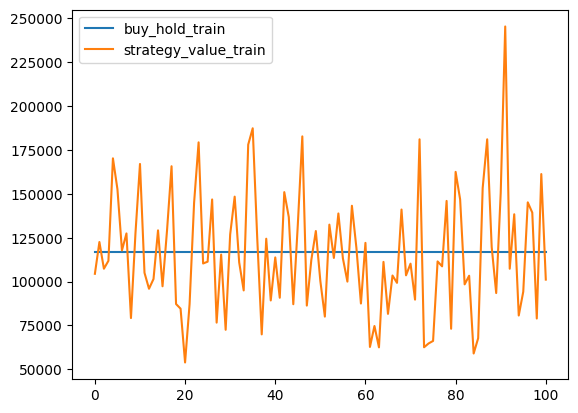

In [7]:
df_tmp[['buy_hold_train', 'strategy_value_train']].plot()

In [9]:
hof.items[0]

In [10]:
# res = pd.read_csv(r"/home/khann/masters/results/run_2024-08-03_08-38/run_info.csv")
# res.columns

In [11]:
best_sol_pop.sort(key = lambda x : x.fitness.values)

In [13]:
# plot_tree(best_sol_pop[0] , name="tree_gen1_best_sol")

In [14]:
best_sol_pop

[]

In [15]:
for i in best_sol_pop:
    per = [k for k in str(i).split("'") if "percent" in k]
    if per:
        print(per[0].split("_")[-1])

In [16]:

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/logbook.pkl", 'rb') as file:
# Serialize the object and write it to the file
    logbook = pickle.load(file)

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/hof.pkl", 'rb') as file:
# Serialize the object and write it to the file
    hof2 = pickle.load(file)

In [17]:
logbook[-1]

{'gen': 50,
 'nevals': 179,
 'avg': array([6556.37844814]),
 'std': array([19013.60832643]),
 'min': array([5.12736613e-10]),
 'max': array([114690.72458003])}

In [18]:
max_lst = []
for i in logbook:
    max_lst.append(i['max'])
x=range(0,len(max_lst))

In [19]:
import matplotlib.pyplot as plt

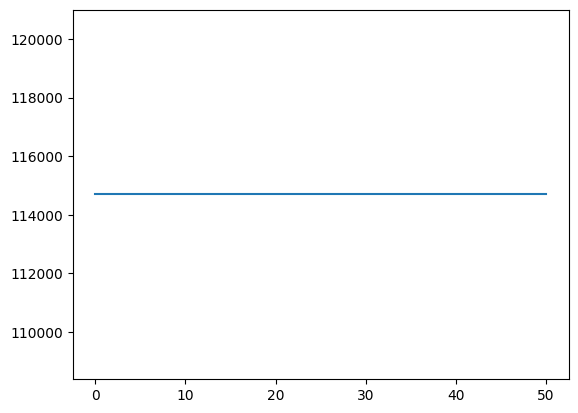

In [20]:
plt.plot(x,max_lst)

In [21]:
max([i.fitness.values for i in best_sol_pop])

ValueError: max() iterable argument is empty

In [22]:
best_solution = best_sol_pop[0]
tc = 0.01
print("TRAIN")
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

IndexError: list index out of range

In [23]:
lst = []
for i in best_sol_pop:
    lst.append(trading_strat(individual = i, df=df_test,pset=pset)[0])

In [24]:
max(lst)

ValueError: max() iterable argument is empty

In [25]:
lst_hof_test = []
for i in hof2:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof2:
    lst_hof_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])

KeyboardInterrupt: 

In [ ]:
[i for i in lst if i>1163]

In [ ]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


In [ ]:
plt.plot(range(1,len(hof2)+1),[i.fitness.values for i in hof2],'r.')
plt.title("Fitness values of the strategies.")


In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')


plt.title("test data")

In [ ]:
[i[0]+i[1]  for i in lst_hof_test]

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]-i[1] for i in lst_hof_train],'k.')


plt.title("train data")
print([i[0]-i[1] for i in lst_hof_train])

In [26]:
with open(rf"/home/khann/masters/results_run2/run_2024-08-10_02-20/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)

In [44]:
lst_hof_test = []
for i in hof.items:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof.items:
    lst_hof_train.append(trading_strat(individual = i, df=df_train,pset=pset)[:2])

In [45]:
lst_hof_test

[(1151.651733489653, -141.6639112406756),
 (507.07754481687255, -236.38466357551806),
 (1064.5363760615685, -108.32900069768539),
 (877.3474364378202, -461.92168704674333),
 (516.7875284889769, -189.2860693700262),
 (619.2600762937308, -189.22270342274783),
 (631.1651305505841, -97.05720008309834),
 (772.9661430832753, -180.58183589864018),
 (722.2726088396089, -210.91985183379848),
 (223.8647183858706, -120.50356953493832)]

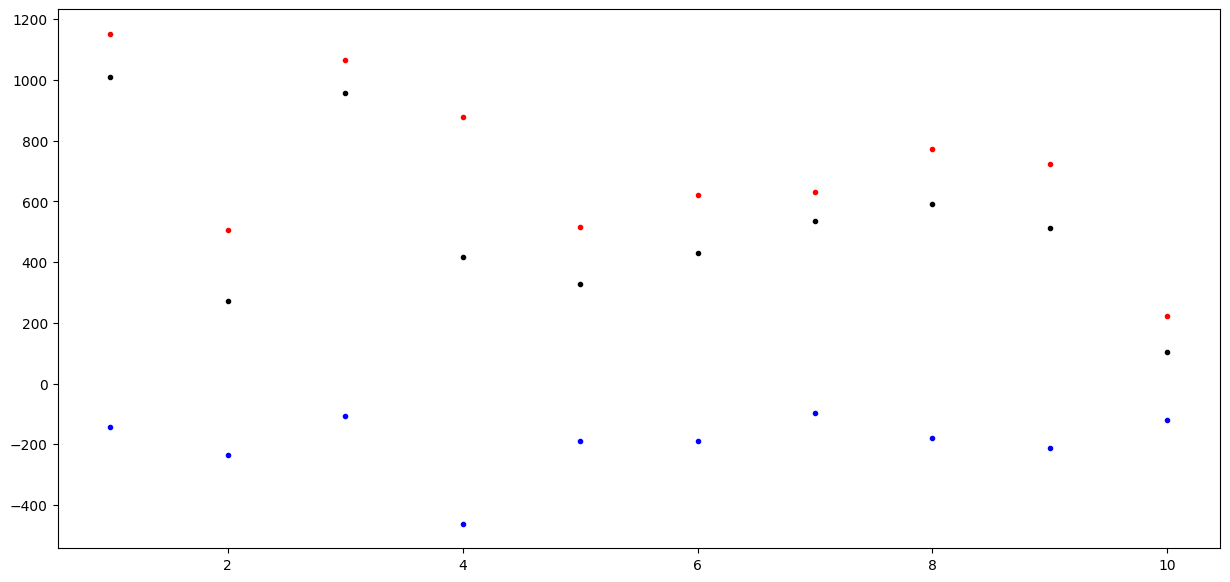

In [46]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')

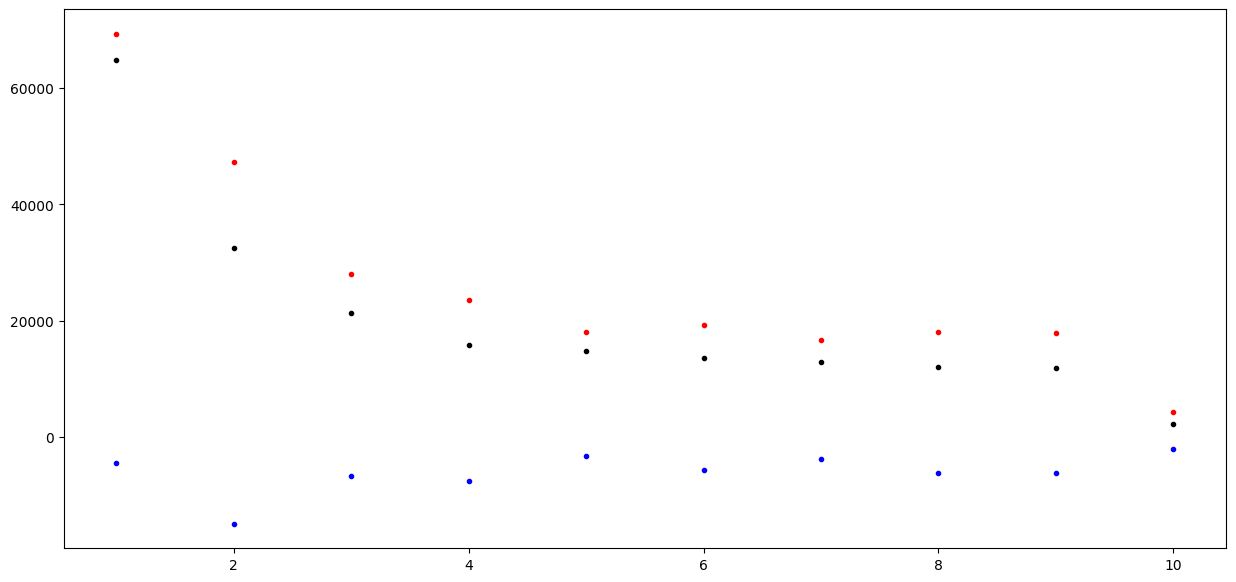

In [47]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_train],'k.')

In [48]:
[i.fitness.values for i in hof.items]

[(64837.23548399476,),
 (32468.812541689185,),
 (21303.933712218295,),
 (15886.453340256161,),
 (14797.078772211806,),
 (13639.857414699782,),
 (12969.345933126475,),
 (12033.395133091653,),
 (11848.93101106483,),
 (2288.881017583112,)]